## Give Me Some Credit: Predicting loan repayment delinquencies

### Abstract
Can we look at a candidate application and tell if they are going to pay back their loans on time with reasonable accuracy?

Yes.

### Introduction
This dataset comes from a [2011 Kaggle competiton](https://www.kaggle.com/c/GiveMeSomeCredit).

Here is the competition overview with one corrected typo:

"Banks play a crucial role in market economies. They decide who can get finance and on what terms and can make or break investment decisions. For markets and society to function, individuals and companies need access to credit. 

Credit scoring algorithms, which make a guess at the probability of default, are the method banks use to determine whether or not a loan should be granted. This competition requires participants to improve on the state of the art in credit scoring, by predicting the probability that somebody will experience financial distress in the next two years.

The goal of this competition is to build a model that (lenders) can use to help make the best financial decisions."

Top scores on the leaderboard were roughly .86.

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from sklearn.model_selection import train_test_split

# Models
from sklearn import ensemble
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import tree
from sklearn.linear_model import LogisticRegression

# The PipeLine
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

import scipy.stats as stats

%matplotlib inline

In [2]:
# Competiton training dataset and outcome variable
credit = pd.read_csv('cs-training.csv', index_col=0)
delinq = credit.SeriousDlqin2yrs

## Brief Data Exploration

In [3]:
credit.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


It looks very nice. The data is pretty clean and it is all numerical. We have a few different kinds of numerical data, though. There are counts (e.g. "Number of times 90 days late"), percentages (e.g. Debt Ratio), and quantities (e.g. "Monthly Income").

In [4]:
credit.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


The "max" row shows some values that do not even appear to be on the same scale. Look at debt ratio. This is supposed to be a percentage, yet someone has reported a debt ratio of 32,966,400%. I'll have to be wary of outliers.

In [5]:
# What will I do with the nulls?
credit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
SeriousDlqin2yrs                        150000 non-null int64
RevolvingUtilizationOfUnsecuredLines    150000 non-null float64
age                                     150000 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    150000 non-null int64
DebtRatio                               150000 non-null float64
MonthlyIncome                           120269 non-null float64
NumberOfOpenCreditLinesAndLoans         150000 non-null int64
NumberOfTimes90DaysLate                 150000 non-null int64
NumberRealEstateLoansOrLines            150000 non-null int64
NumberOfTime60-89DaysPastDueNotWorse    150000 non-null int64
NumberOfDependents                      146076 non-null float64
dtypes: float64(4), int64(7)
memory usage: 13.7 MB


Roughly 20% of the people in our dataset did not report a monthly income. Some of those did not report their number of dependents either. I am going to exclude them for now. But I do not think it is wise to give up 20% of our business/data. For this reason, I will try to impute values for these later, when I am testing the model. This will allow me to get instant feedback and know if I am making good decisions for the values I impute.

In [6]:
credit_dropna = credit.dropna()
delinq_dropna = credit_dropna['SeriousDlqin2yrs']

In [7]:
credit_dropna.shape

(120269, 11)

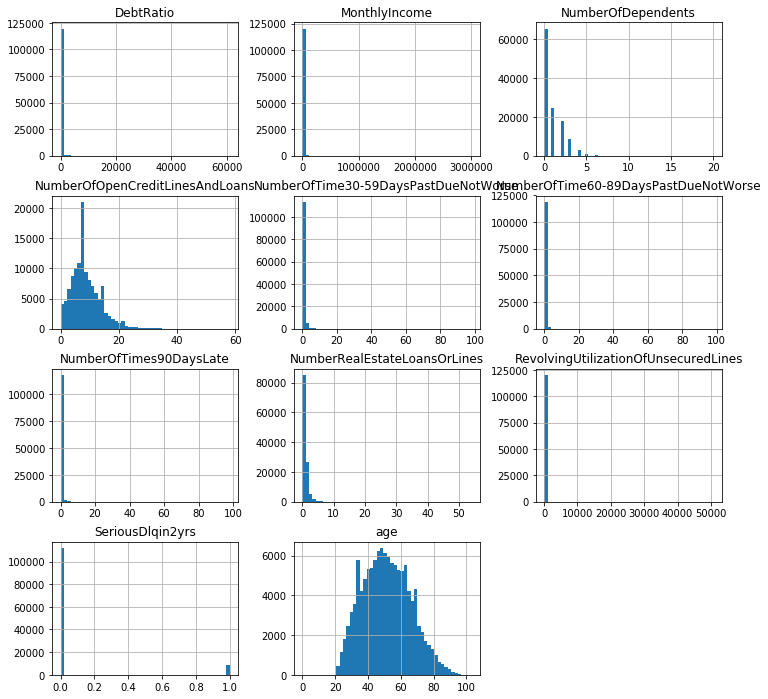

In [8]:
credit_dropna.hist(bins=50, figsize=(12,12))
plt.show()

The above histogram is just a first peek. From it, we can confirm hat most of our variables are heavily skewed right.

From what we can see above, age would be normally distributed but we cannot approve loans for little children. And our view of many of the variables is very hard to make out because of the extreme values present.

The variables containing these extreme values include:
- Debt Ratio
- Monthly Income
- Number of times 30-59 days past due not worse
- Number of times 60-89 days past due not worse
- Number of times 90 days late
- Number of real estate loans or lines (although this one is not as extreme)
- Revoliving utilization of unsecured lines

Because so many of my variables are non-normal, I am already starting to lean towards using a model that does not assume normality of the variables. Transforming these variables to try to make them normal, when they are closer to a poisson distribution would not make much sense and be a lot of work.

So, what am I going to do about these outliers? I will deal with them at the same time as I deal with the missing values, at the modeling stage.

Our binary outcome variable "SeriousDlqin2yrs" is showing some class imbalance. This tells me that a standard cross-validation score will not be sufficient and I will need to use the area under the precision-recall curve to measure success.

In [9]:
# Putting data into stratified train/test groups
X_train_dropna, X_test_dropna, y_train_dropna, y_test_dropna = train_test_split(credit_dropna,
                                                    delinq_dropna, 
                                                    test_size=.2, 
                                                    stratify=delinq_dropna, 
                                                    random_state=24
)

### Baseline of performance
At this point, I would like to run the raw data through some models to get a performance baseline. For this, I am simply going to drop all the missing values.

The models that I will be testing out are K-Nearest Neighbors, Random Forest, and Gradient Boosting. I chose these because they will still perform with non-normal data.

Another thing that I need to take into account is the weight. Presumably, it is worse to let someone take a loan and then have them default than it would be for us to decline someone a loan when they actually would have been good for it. But which is worse: denying two good borrowers or accepting one bad borrower (2:1)? Maybe it's more like 5:4? 20:1? This is important information to optimizing the model.

The competition specified that the measure for performance will be area under the curve. This pretty much answers the question of the weighting for me.

It is important to identify the true negatives as well as the true positives so my measurement will be the area under the ROC rather than the Precision-Recall curve because that does not take true negatives into account and those true negatives are where we are going to be making our money!

In [10]:
y_test_dropna.value_counts()

0    22383
1     1671
Name: SeriousDlqin2yrs, dtype: int64

In [11]:
wontyoube = KNeighborsClassifier()
pre_X = X_train_dropna.drop(columns='SeriousDlqin2yrs')
pre_y = y_train_dropna
wontyoube.fit(pre_X, pre_y)

knn_X_test_dropna_pred = wontyoube.predict(X_test_dropna.drop(columns='SeriousDlqin2yrs'))

sklearn.metrics.roc_auc_score(y_test_dropna, knn_X_test_dropna_pred)

0.5080472717055479

In [12]:
randfor = ensemble.RandomForestClassifier(n_estimators=10)
randfor.fit(pre_X, pre_y)

randfor_X_train_dropna_pred = randfor.predict(pre_X)

sklearn.metrics.roc_auc_score(y_train_dropna, randfor_X_train_dropna_pred)

0.9323982324061214

In [13]:
randfor_X_test_dropna_pred = randfor.predict(X_test_dropna.drop(columns='SeriousDlqin2yrs'))

sklearn.metrics.roc_auc_score(y_test_dropna, randfor_X_test_dropna_pred)

0.5789923681339655

Random Forest overfits a lot.

In [14]:
gradboost = ensemble.GradientBoostingClassifier()
gradboost.fit(pre_X, pre_y)

gradboost_X_train_dropna_pred = gradboost.predict(pre_X)

sklearn.metrics.roc_auc_score(y_train_dropna, gradboost_X_train_dropna_pred)

0.5993879627911614

In [15]:
gradboost_X_test_dropna_pred = gradboost.predict(X_test_dropna.drop(columns='SeriousDlqin2yrs'))

sklearn.metrics.roc_auc_score(y_test_dropna, gradboost_X_test_dropna_pred)

0.5928282885887926

GradientBoosting is slightly more accurate on the test data than Random Forest and does not seem to be overfitting.

In [ ]:
logreg = LogisticRegression(penalty='l1', solver='liblinear')
logreg.fit(pre_X, pre_y)

logreg_X_test_dropna_pred = logreg.predict(X_test_dropna.drop(columns='SeriousDlqin2yrs'))

sklearn.metrics.roc_auc_score(y_test_dropna, logreg_X_test_dropna_pred)

# L2 did slightly worse

At a glance, we can see that gradient boosting and random forest seem significantly better for this problem than K-Nearest Neighbors and logistic regression. We now have a baseline performance that we can try to improve upon.

# Feature Engineering
Feature Engineering based on the univariate exploration I have done so far.

I will do more Feature Engineering based on Bivariate exploration in a later section.

In [ ]:
credit.columns

In [ ]:
credit.describe()

In [ ]:
# Functions for creating categorical variables
def late_cat(times_late):
    """Takes count of times_late, returns one of four categories"""
    if times_late == 0:
        return "0"
    elif times_late < 6:
        return "1-5"
    elif times_late < 20:
        return "6-19"
    else:
        return "> 19"
    
def debt_cat(debtratio):
    if debtratio == 0:
        return "0"
    elif debtratio < .4:
        return "< .4"
    elif debtratio < 1:
        return ".4-1"
    elif debtratio < 5:
        return "1-5"
    elif debtratio < 40:
        return "5-40"
    else:
        return "> 40"
    
def income_cat(monthlyincome):
    if monthlyincome < 600:
        return "< 600"
    elif monthlyincome < 1200:
        return "600-1200"
    elif monthlyincome < 1800:
        return "1200-1800"
    elif monthlyincome < 3000:
        return "1800-3000"
    elif monthlyincome < 4800:
        return "3000-4800"
    elif monthlyincome < 6600:
        return "4800-6600"
    elif monthlyincome < 10000:
        return "6600-10000"
    else:
        return "> 10000"
    
def revolving_cat(revolvinguse):
    if revolvinguse == 0:
        return "0"
    elif revolvinguse < .4:
        return "< .4"
    elif revolvinguse < 1:
        return ".4-1"
    elif revolvinguse < 5:
        return "1-5"
    elif revolvinguse < 40:
        return "5-40"
    else:
        return "> 40"    
    
def lines_cat(linesandloans):
    if linesandloans == 0:
        return "0"
    elif linesandloans < 4:
        return "1-3"
    elif linesandloans < 10:
        return "4-9"
    elif linesandloans < 18:
        return "10-17"
    else:
        return "> 17"
    
def real_estate_cat(realestateloans):
    if realestateloans == 0:
        return "0"
    elif realestateloans < 4:
        return "1-3"
    elif realestateloans < 10:
        return "4-9"
    elif realestateloans < 18:
        return "10-17"
    else:
        return "> 17"
    
def age_cat(age):
    if age < 20:
        return "< 24"
    elif age < 30:
        return "< 30"
    elif age < 40:
        return "30-39"
    elif age < 50:
        return "40-49"
    elif age < 60:
        return "50-59"
    elif age < 70:
        return "60-69"
    elif age < 80:
        return "80-89"
    else:
        return "> 89"
    
def dependents_cat(dependents):
    if dependents == 0:
        return "0"
    elif dependents == 1:
        return "1"
    elif dependents < 5:
        return "2-4"
    elif dependents < 8:
        return "5-7"
    elif dependents < 12:
        return "8-11"
    else:
        return "> 11"
    

I have now created functions for making the variables into categorical ones. I will explore the different categories next.

In [ ]:
# Winsorize
def winsorize(number, cutoff):
    if number > cutoff:
        return cutoff
    else:
        return number

# Impute monthly income to $3400
income_imputer3400 = SimpleImputer(strategy='constant', fill_value=3400.0)

# Impute number of dependents to mean
dependent_imputer_mean = SimpleImputer()

# Min/Max Scaler
scaler = MinMaxScaler()

In [ ]:
def lateness_df(df, col_list=['NumberOfTime30-59DaysPastDueNotWorse',
                              'NumberOfTime60-89DaysPastDueNotWorse',
                              'NumberOfTimes90DaysLate']):
    """Takes DataFrame, returns w/ categorical lateness columns"""
    for col in col_list:
        df[col] = df[col].apply(lambda x: lateness(x))
    return df

def winsorized_df(df, cutoff_list):
    """Takes DataFrame, returns w/ cutoff_list columns winsorized"""
    for col, cutoff in cutoff_list:
        df[col] = df[col].apply(lambda x: winsorize(x, cutoff))
    return df

def imputed_df(df, col='MonthlyIncome'):
    """Takes DataFrame, returns DataFrame w/ MonthlyIncome imputed to fill_val"""
    df[col] = income_imputer3400.fit_transform(df[col].values.reshape(-1, 1))
    return df

def imputed_dependents_df(df, col='NumberOfDependents'):
    """Takes DataFrame, returns DataFrame w/ NumberOfDependents nulls imputed to mean"""
    df[col] = SimpleImputer().fit_transform(df[col].values.reshape(-1, 1))
    return df
    
def min_max_df(df):
    """Takes DataFrame, returns min/max scaled DataFrame"""
    df[df.columns] = scaler.fit_transform(df[df.columns])
    return df

In [ ]:
winsorize_cutoffs = [('DebtRatio', 100), 
                     ('MonthlyIncome', 20000),
                     ('RevolvingUtilizationOfUnsecuredLines', 1)]

lateness_cutoffs = [('NumberOfTime30-59DaysPastDueNotWorse', 10),
                    ('NumberOfTime60-89DaysPastDueNotWorse', 10),
                    ('NumberOfTimes90DaysLate', 10)]

In [ ]:
# Re-usable functions to create various DataFrames for model testing.

def impute_scale(df):
    """Takes df, returns df with imputed nulls and min/max scaled"""
    df = imputed_df(df)
    df = imputed_dependents_df(df)
    df = min_max_df(df)
    return(df)

def impute_win_scale(df):
    """Takes df, imputes nulls, winsorizes outliers, min/max scales"""
    df = imputed_df(df)
    df = imputed_dependents_df(df)
    df = winsorized_df(df, winsorize_cutoffs)
    df = min_max_df(df)
    return df



# Model Testing with Univariate Feature Engineering

In [ ]:
uni = credit.copy()

In [ ]:
# Original data with imputed nulls and scaled
uni_impute_scale = impute_scale(uni)

# Original data with imputed nulls, winsorized, and scaled
uni_impute_win_scale = impute_win_scale(uni)

In [ ]:
# Putting data into stratified train/test groups
uniX_train, uniX_test, uniy_train, uniy_test = train_test_split(uni_impute_scale,
                                                    delinq, 
                                                    test_size=.2, 
                                                    stratify=delinq, 
                                                    random_state=24
)

uni_features = uniX_train.copy()
uni_features = uni_features.drop(columns='SeriousDlqin2yrs')

In [ ]:
uniX_test.head()

In [ ]:
# This is a test of random forest on the data with nulls imputed and variables scaled
uni_randfor = ensemble.RandomForestClassifier(n_estimators=20)
uni_randfor.fit(uni_features, uniy_train)

uni_randfor_X_train_pred = randfor.predict(uniX_test.drop(columns='SeriousDlqin2yrs'))

sklearn.metrics.roc_auc_score(uniy_test, uni_randfor_X_train_pred)

In [ ]:
# This is a test of gradient boosting on the data with nulls imputed and variables scaled
uni_gradboost = ensemble.GradientBoostingClassifier()
uni_gradboost.fit(uni_features, uniy_train)

uni_gradboost_X_train_pred = uni_gradboost.predict(uniX_test.drop(columns='SeriousDlqin2yrs'))

sklearn.metrics.roc_auc_score(uniy_test, uni_gradboost_X_train_pred)

Well, ok, it seems that my univariate attempts did nothing.

I should consider making as many of the original variables into categories as possible.

# Bivariate data exploration

I explored the individual variables and decided to winsorize them. I also created a new DF to keep track of those I changed but at this point, I don't think it tells us anything.

I still need to:
- Keep in mind the choices I made
    
    - The number of people who were late a lot don't have many credit lines open.
    - Debt ratio seems fishy
    - I need to do something about the missing values in the # of dependents variable
    
    - Some variables probably only matter when combined logically with other variables.

    - Maybe I should consider pre-qualifying many of the candidates to shrink down the dataset.
        - Or do algorithms need this/do this?